# Importing Needed Libraries

In [92]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

import keras
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [45]:
#Preprocessing dataset
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler


def format_Dataframes(data_path:str=None, type_file:str="csv",
                      timestamp_col_name: str="Ngày") -> pd.DataFrame:

    '''
    data_path: Dataset path.
    type: File type dataset, for example: data.csv, data.xlsx, ...
    '''

    if data_path is None or os.path.exists(data_path) == False:
        print("The path of dataset does not exist. Please check again !!")
    else:

        df = None
        if type_file == "csv":
            df = pd.read_csv(data_path)
        elif type_file == "xlsx":
            df = pd.read_excel(data_path)
        else:
            print("Opening this file type is not supported !!")

        column_names = ["Tên", "Ngày", 'Đóng cửa', 'Điều chỉnh', "Thay đổi", "Thay đổi 1", "%", 
        'Khối lượng (Khớp lệnh)', 'Giá trị (Khớp lệnh)', 'Khối lượng (Thỏa thuận)', 'Giá trị (Thỏa thuận)', 
        'Mở cửa', 'Cao nhất', 'Thấp nhất']


        new_column_names = df.iloc[0]
        df = df[1:]
        df.columns = new_column_names
        df.reset_index(drop=True, inplace=True)
        df.columns = column_names

        for name in df.columns:
            if name not in ["Tên", "Ngày", 'Điều chỉnh', "Thay đổi", "Thay đổi 1", "%"]:
                df[name] =  pd.to_numeric(df[name], errors='coerce')
        
        return df

In [46]:
data_raw = format_Dataframes('/kaggle/input/fpt-stock/FPT_stock.xlsx','xlsx')
data_raw

,Tên,Ngày,Đóng cửa,Điều chỉnh,Thay đổi,Thay đổi 1,%,Khối lượng (Khớp lệnh),Giá trị (Khớp lệnh),Khối lượng (Thỏa thuận),Giá trị (Thỏa thuận),Mở cửa,Cao nhất,Thấp nhất
0,FPT,2024-05-21,136.0,--,3(2.26,3(2.26%),%),NaN,467.06,734.400,99.45,134.0,136.0,133.5
1,FPT,2024-05-20,133.0,--,-1.5(-1.12,-1.5(-1.12%),%),NaN,270.50,NaN,152.86,135.2,136.1,133.0
2,FPT,2024-05-17,134.5,--,-0.9(-0.66,-0.9(-0.66%),%),NaN,310.27,642.601,86.43,135.4,136.0,133.7
3,FPT,2024-05-16,135.4,--,1.3(0.97,1.3(0.97%),%),NaN,423.78,924.900,119.98,135.6,137.3,134.2
4,FPT,2024-05-15,134.1,--,3.6(2.76,3.6(2.76%),%),NaN,485.07,NaN,139.80,131.5,134.5,131.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4338,FPT,2006-12-19,486.0,2024-02-16 00:00:00,23(4.97,23(4.97%),%),137.52,0.07,0.000,0.00,486.0,486.0,486.0
4339,FPT,2006-12-18,463.0,15.44,22(4.99,22(4.99%),%),215.79,0.10,10.000,0.00,463.0,463.0,463.0
4340,FPT,2006-12-15,441.0,2024-07-14 00:00:00,21(5.00,21(5.00%),%),265.30,0.12,30.000,0.01,441.0,441.0,441.0
4341,FPT,2006-12-14,420.0,14,20(5.00,20(5.00%),%),280.71,0.12,96.000,0.04,420.0,420.0,420.0


In [47]:
def preprocessing_dataframe(dataFrame: pd.DataFrame, fillna: str="mean", scale: str="std") -> pd.DataFrame:

    '''
    dataFrame: A data frame is data after reading from a csv file and having run it through the format_Dataframes() function.
    fillna: Type of fill data NaN, Null or None; [None, Zero, Mean].
    scale: Type of scale; [MinMaxScaler, StandardScaler]
    '''

    dataFrame.drop(columns=['Điều chỉnh', 'Thay đổi', 'Thay đổi 1', '%'], inplace=True)
    scaler = None

    if fillna == "zero":
        float_columns = dataFrame.select_dtypes(include=['float']).columns
        dataFrame[float_columns] = dataFrame[float_columns].fillna(0)
        int_columns = dataFrame.select_dtypes(include=['int']).columns
        dataFrame[int_columns] = dataFrame[int_columns].fillna(0)
    elif fillna == "mean":
        float_columns = dataFrame.select_dtypes(include=['float']).columns
        dataFrame[float_columns] = dataFrame[float_columns].fillna(dataFrame[float_columns].mean())
        int_columns = dataFrame.select_dtypes(include=['int']).columns
        dataFrame[int_columns] = dataFrame[int_columns].fillna(dataFrame[int_columns].mean())
    else:
        dataFrame.dropna(inplace=True)

    tmp_dataFrame_day = dataFrame["Ngày"]
    tmp_dataFrame_day.reset_index(drop=True, inplace=True)
    tmp_dataFrame_name = dataFrame["Tên"]
    tmp_dataFrame_name.reset_index(drop=True, inplace=True)
    dataFrame.drop(columns=["Ngày", "Tên"], inplace=True)
    dataFrame.reset_index(drop=True, inplace=True)


    if scale == "std":
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()

    tmp_scaler = scaler.fit_transform(dataFrame)
    dataFrame =  pd.DataFrame(tmp_scaler, columns=dataFrame.columns)

    # tmp_dataFrame = pd.concat([tmp_dataFrame_day, tmp_dataFrame_name], axis=1)
    dataFrame = pd.concat([tmp_dataFrame_day, dataFrame], axis=1)
    dataFrame.set_index("Ngày", inplace=True)
    dataFrame.sort_values(by="Ngày", inplace=True)

    return dataFrame

In [48]:
data_FPT = preprocessing_dataframe(data_raw)
data_FPT

,Đóng cửa,Khối lượng (Khớp lệnh),Giá trị (Khớp lệnh),Khối lượng (Thỏa thuận),Giá trị (Thỏa thuận),Mở cửa,Cao nhất,Thấp nhất
Ngày,,,,,,,,
2006-12-13,0.581160,0.083545,0.000035,0.000000,0.000000,0.581226,0.574601,0.581292
2006-12-14,0.612771,0.280761,0.000142,0.096823,0.000049,0.612832,0.605881,0.612893
2006-12-15,0.645962,0.265348,0.000142,0.030257,0.000012,0.646018,0.638724,0.646074
2006-12-18,0.680733,0.215829,0.000118,0.010086,0.000000,0.680784,0.673131,0.680834
2006-12-19,0.717086,0.137545,0.000083,0.000000,0.000000,0.717130,0.709102,0.717175
...,...,...,...,...,...,...,...,...
2024-05-15,0.160898,0.386191,0.572746,0.099514,0.170915,0.156922,0.159368,0.156739
2024-05-16,0.162952,0.386191,0.500378,0.932829,0.146684,0.163401,0.163747,0.161321
2024-05-17,0.161530,0.386191,0.366351,0.648110,0.105667,0.163085,0.161714,0.160531


In [50]:
data_FPT.isnull().sum()

Đóng cửa                   0
Khối lượng (Khớp lệnh)     0
Giá trị (Khớp lệnh)        0
Khối lượng (Thỏa thuận)    0
Giá trị (Thỏa thuận)       0
Mở cửa                     0
Cao nhất                   0
Thấp nhất                  0
dtype: int64

## Reading The Data

# Data Exploration

In [51]:
data_FPT.head()

,Đóng cửa,Khối lượng (Khớp lệnh),Giá trị (Khớp lệnh),Khối lượng (Thỏa thuận),Giá trị (Thỏa thuận),Mở cửa,Cao nhất,Thấp nhất
Ngày,,,,,,,,
2006-12-13,0.581160,0.083545,0.000035,0.000000,0.000000,0.581226,0.574601,0.581292
2006-12-14,0.612771,0.280761,0.000142,0.096823,0.000049,0.612832,0.605881,0.612893
2006-12-15,0.645962,0.265348,0.000142,0.030257,0.000012,0.646018,0.638724,0.646074
2006-12-18,0.680733,0.215829,0.000118,0.010086,0.000000,0.680784,0.673131,0.680834
2006-12-19,0.717086,0.137545,0.000083,0.000000,0.000000,0.717130,0.709102,0.717175


In [52]:
data_FPT.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4343 entries, 2006-12-13 to 2024-05-21
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Đóng cửa                 4343 non-null   float64
 1   Khối lượng (Khớp lệnh)   4343 non-null   float64
 2   Giá trị (Khớp lệnh)      4343 non-null   float64
 3   Khối lượng (Thỏa thuận)  4343 non-null   float64
 4   Giá trị (Thỏa thuận)     4343 non-null   float64
 5   Mở cửa                   4343 non-null   float64
 6   Cao nhất                 4343 non-null   float64
 7   Thấp nhất                4343 non-null   float64
dtypes: float64(8)
memory usage: 305.4 KB


In [53]:
data_FPT.describe()

,Đóng cửa,Khối lượng (Khớp lệnh),Giá trị (Khớp lệnh),Khối lượng (Thỏa thuận),Giá trị (Thỏa thuận),Mở cửa,Cao nhất,Thấp nhất
count,4343.000000,4343.000000,4343.000000,4343.000000,4343.000000,4343.000000,4343.000000,4343.000000
mean,0.077245,0.386191,0.087992,0.099514,0.022386,0.077426,0.077282,0.076303
std,0.133764,0.214971,0.101205,0.188193,0.064048,0.133862,0.133581,0.132555
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.023392,0.239403,0.022747,0.000000,0.000000,0.023388,0.023303,0.023187
50%,0.035088,0.386191,0.060407,0.000000,0.000000,0.035240,0.035815,0.034603
75%,0.078552,0.421741,0.104396,0.099514,0.022386,0.078382,0.078433,0.077263
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Data Preprocessing

### Choosing Prediction Column

In [59]:
dataset = data_FPT["Đóng cửa"]
dataset = pd.DataFrame(dataset)
data = dataset.values
data.shape

(4343, 1)

In [60]:
data

array([[0.58116011],
       [0.61277067],
       [0.64596175],
       ...,
       [0.16152995],
       [0.15915916],
       [0.16390074]])

### Normalizing Data

In [61]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))

In [62]:
scaled_data

array([[0.58116011],
       [0.61277067],
       [0.64596175],
       ...,
       [0.16152995],
       [0.15915916],
       [0.16390074]])

### Splitting the Data

In [63]:
# 75% to Train , 25% to Test
train_size = int(len(data)*.75)
test_size = len(data) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = scaled_data[ :train_size , 0:1 ]
test_data = scaled_data[ train_size-60: , 0:1 ]

Train Size : 3257 Test Size : 1086


In [64]:
train_data

array([[0.58116011],
       [0.61277067],
       [0.64596175],
       ...,
       [0.03903904],
       [0.04077762],
       [0.03872293]])

In [65]:
train_data.shape, test_data.shape

((3257, 1), (1146, 1))

### Creating training set

In [66]:
# Creating a Training set with 60 time-steps and 1 output
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [67]:
train_data

array([[0.58116011],
       [0.61277067],
       [0.64596175],
       ...,
       [0.03903904],
       [0.04077762],
       [0.03872293]])

In [68]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [69]:
# Reshaping the input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [70]:
x_train.shape , y_train.shape

((3197, 60, 1), (3197,))

# CNN Model

### Model Dtructure

In [93]:


model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(x_train.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics="mean_absolute_error")

In [94]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 29, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 27, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 128)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 1664)              0         
                                                                 
 dense_6 (Dense)             (None, 64)               

### Model Training

In [95]:
# Fitting the LSTM to the Training set
callbacks = [EarlyStopping(monitor= 'loss', patience= 10 , restore_best_weights= True)]
history = model.fit(x_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks )

Epoch 1/100
100/100 [==============================] - 2s 9ms/step - loss: 0.0018 - mean_absolute_error: 0.0186
Epoch 2/100
100/100 [==============================] - 1s 8ms/step - loss: 6.8589e-04 - mean_absolute_error: 0.0130
Epoch 3/100
100/100 [==============================] - 1s 9ms/step - loss: 5.7557e-04 - mean_absolute_error: 0.0121
Epoch 4/100
100/100 [==============================] - 1s 8ms/step - loss: 5.3945e-04 - mean_absolute_error: 0.0122
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: 5.4099e-04 - mean_absolute_error: 0.0108
Epoch 6/100
100/100 [==============================] - 1s 8ms/step - loss: 8.6144e-04 - mean_absolute_error: 0.0135
Epoch 7/100
100/100 [==============================] - 1s 8ms/step - loss: 4.2685e-04 - mean_absolute_error: 0.0085
Epoch 8/100
100/100 [==============================] - 1s 8ms/step - loss: 3.5165e-04 - mean_absolute_error: 0.0077
Epoch 9/100
100/100 [==============================] - 1s 8ms/step - loss: 3

### Model Evaluation

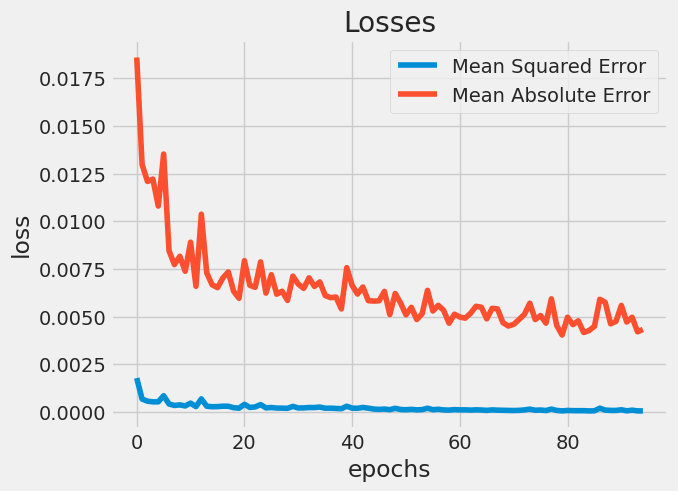

In [96]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Predection

### Creating testing set

In [97]:
# Creating a testing set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [98]:
x_test.shape , y_test.shape

((1086, 60, 1), (1086,))

In [99]:
#inverse y_test scaling
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

34/34 [==============================] - 0s 3ms/step


(1086, 1)

# MSE,MAE,HUBER

In [100]:
huber_loss = Huber(delta=1.0)
# Tính toán MSE
mse = tf.keras.losses.mean_squared_error(y_test, predictions).numpy()
print(f'MSE: {np.mean(mse)}')

# Tính toán MAE
mae = tf.keras.losses.mean_absolute_error(y_test, predictions).numpy()
print(f'MAE: {np.mean(mae)}')

# Tính toán Huber loss
huber_loss_value = huber_loss(y_test, predictions).numpy()
print(f'Huber Loss: {np.mean(huber_loss_value)}')

MSE: 0.0014773905277252197
MAE: 0.030279820784926414
Huber Loss: 0.0007386952638626099


Text(0.5, 1.0, 'Evaluation Metrics on Test Data')

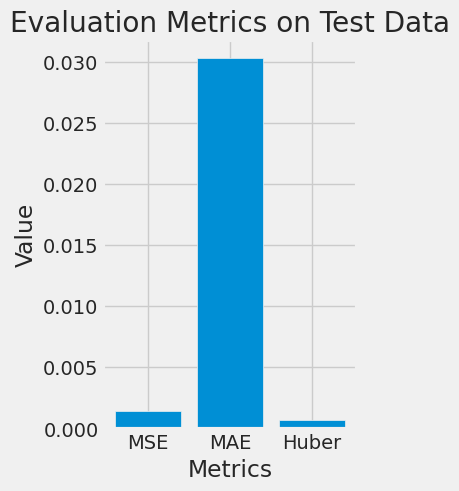

In [101]:
plt.subplot(1, 2, 2)
plt.bar(['MSE', 'MAE', 'Huber'], [np.mean(mse), np.mean(mae), np.mean(huber_loss_value)])
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Evaluation Metrics on Test Data')
